In [2]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    sys.path.append(r'C:\_Lib\python')
    from BEMHelper import interpolate_slow
    from slab.circuitqed import SingleElectron
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis, single_electron as se
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
# %config InlineBackend.figure_format='retina'

Warning serial library import failed.
Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick
Warning no qutip!


# Single-tone signals as function of $g$ and $\Gamma$

In [3]:
# this assumes kappa ~ 0.5 kappa_in + 0.5 kappa_out (no internal loss)
g_guess = 5E6
gamma_guess = 150E6

f_cavity = 6.397E9
detunings = np.linspace(-1.0E6, 1.0E6, 151)
detuning_std = 300e3 #kappa_tot
f_drive = f_cavity + detunings
Q_cavity = 20E3
kappa_tot = f_cavity / Q_cavity
Vtrap = np.linspace(0.150, 0.200,10000)

First check the voltage to frequency, and make sure that it crosses the resonator for some trap voltage. 

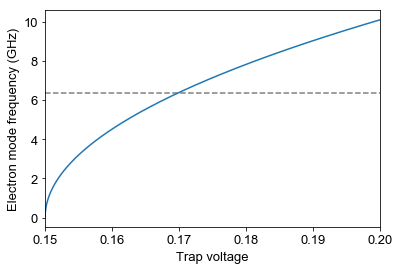

In [5]:
plt.figure()
common.configure_axes(13)
plt.plot(Vtrap, 1/1E9 * se.voltage_to_frequency(Vtrap, V_start=0.150, V_crossing=0.170, f_cavity=f_cavity))
plt.xlabel("Trap voltage")
plt.ylabel("Electron mode frequency (GHz)")
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.hlines(f_cavity / 1E9, np.min(Vtrap), np.max(Vtrap), linestyles='--', color='gray')

Now I calculate the phase and magnitude signal for different $g$'s and $\Gamma$'s in the range of our experiment. I log the depth of the dip on resonance and the maximum phase swing just above and below the crossing with the resonator. Note that this calculation doesn't take into account any of the driving detuning. I assume the driving is always on resonance.

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


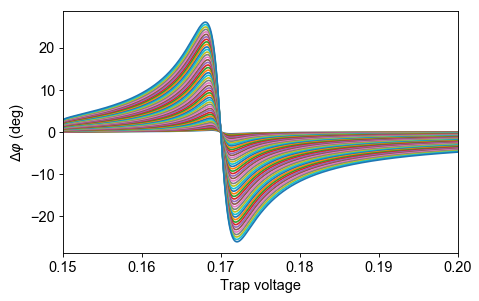

In [94]:
gs = np.linspace(1E6, 10E6, 51)
gammas = np.linspace(20E6, 200E6, 101)

dip_depth, phase_signal = list(), list()

plt.figure(figsize=(14.,4.))
plt.subplot(121)

for coupling in gs: 
    for loss in gammas:

        s21_mag, s21_phi = se.s21(kappa_tot=kappa_tot, g=coupling, f_cavity=f_cavity, f_drive=f_cavity, 
                                  f_electron=se.voltage_to_frequency(Vtrap, V_start=0.150, V_crossing=0.170, f_cavity=f_cavity), 
                                  gamma=loss)
        
        dip_depth.append(np.min(s21_mag))
        phase_signal.append((np.max(s21_phi) - np.min(s21_phi))*180/np.pi)

    
    plt.plot(Vtrap, s21_phi * 180/np.pi, label="")

plt.xlabel("Trap voltage")
plt.ylabel(r"$\Delta \varphi$ (deg)")
plt.legend(loc=0, prop={"size" : 10}, frameon=False)
plt.xlim(np.min(Vtrap), np.max(Vtrap))

dip_depth = np.reshape(np.array(dip_depth), (len(gs), len(gammas)))
phase_signal = np.reshape(np.array(phase_signal), (len(gs), len(gammas)))

## Dip depth as function of $g$ and $\Gamma$

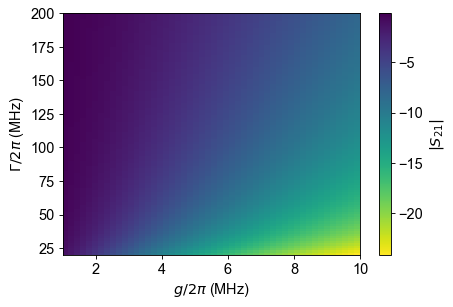

In [96]:
plt.figure()
plt.pcolormesh(gs/1e6, gammas/1e6, 20 * np.log10(dip_depth.T), cmap=plt.cm.viridis_r)
plt.xlabel("$g/2\pi$ (MHz)")
plt.ylabel("$\Gamma/2\pi$ (MHz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$|S_{21}|$")

## Phase swing as function of $g$ and $\Gamma$

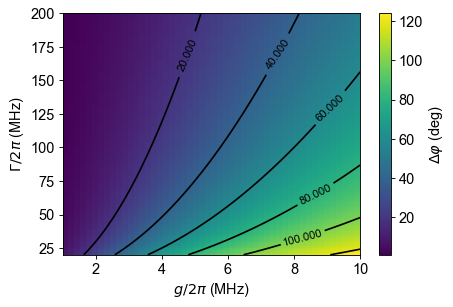

In [79]:
plt.figure()
CS = plt.contour(gs/1e6, gammas/1e6, phase_signal.T, colors='k', )
plt.pcolormesh(gs/1e6, gammas/1e6, phase_signal.T)

plt.clabel(CS, CS.levels, inline=True, fontsize=10)

plt.xlabel("$g/2\pi$ (MHz)")
plt.ylabel("$\Gamma/2\pi$ (MHz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\Delta \varphi$ (deg)")

In the two figures below I can look at some of the asymptotic behavior in $g$ and $\Gamma$. First of all, let's look at slices of $\Delta \varphi$ as function of $g$. It's clear that for the highest value of $\Gamma$, the phase swing is linear in $g$. 

(1.0, 10.0)

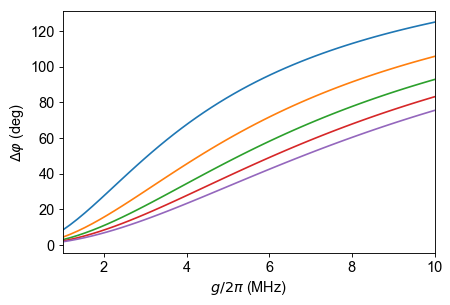

In [95]:
plt.figure()

for gamma_oi in [20e6, 40e6, 60e6, 80e6, 100e6]:

    gamma_idx = common.find_nearest(gammas, gamma_oi)

    plt.plot(gs/1e6, phase_signal.T[gamma_idx, :])

plt.xlabel("$g/2\pi$ (MHz)")
plt.ylabel(r"$\Delta \varphi$ (deg)")
plt.xlim(np.min(gs/1e6), np.max(gs)/1e6)

Below I do the same thing for $\Delta \varphi$ as function of $\Gamma$. For the lowest value of $g$, the response is parallel to the line $1 / \Gamma$ in log-log space.

(20.0, 200.0)

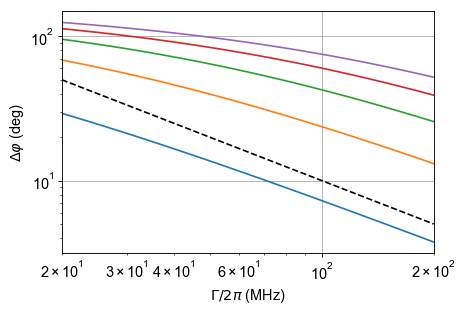

In [93]:
plt.figure()

for g_oi in [2e6, 4e6, 6e6, 8e6, 10e6]:

    g_idx = common.find_nearest(gs, g_oi)

    plt.plot(gammas/1e6, phase_signal.T[:, g_idx])

plt.xlabel("$\Gamma/2\pi$ (MHz)")
plt.ylabel(r"$\Delta \varphi$ (deg)")
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.plot(gammas/1e6, 1e9/gammas, '--', color='k')
plt.xlim(np.min(gammas/1e6), np.max(gammas)/1e6)

# Power dependence on resonance $\Delta = 0$

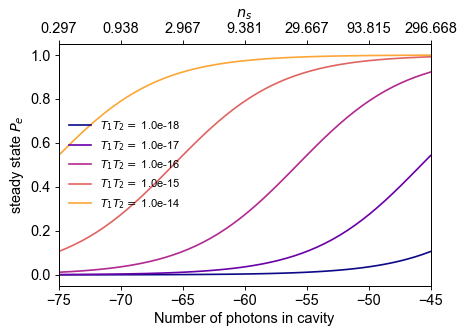

In [23]:
g = 10E6
T1T2s = np.logspace(-18, -14, 5)
# ns = np.logspace(-1, 4)
Ps = np.linspace(-75, -45)
ns = 10 ** ((Ps - 70 - 30)/10.) / (6.63E-34 * 6.397E9 * 2 * np.pi * 400E3)

def Pe(n, t1t2):
    return 1 / (1 + 1 / (4 * n * g ** 2 * t1t2))

fig = plt.figure()
common.configure_axes(13)
for jj, t1t2 in enumerate(T1T2s):
    plt.plot(Ps, Pe(ns, t1t2), '-', color=common.rgb(jj, len(T1T2s), cmap=plt.cm.plasma), 
            label="$T_1 T_2 = $ %.1e" % t1t2)
plt.xlabel("Number of photons in cavity")
plt.ylabel("steady state $P_e$")
plt.xlim(np.min(Ps), np.max(Ps))
plt.legend(loc=0, frameon=False, prop={"size" : 10})

ax1 = plt.gca()
ax2 = plt.twiny()

new_tick_locations = np.arange(-75, -40, 5)

def tick_function(X):
    V = 10 ** ((X - 70 - 30)/10.) / (6.63E-34 * 6.397E9 * 2 * np.pi * 400E3)
    return ["%.3f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
# ax2.set_xscale('log')
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"$n_s$")

# Conclusion 

We conclude that for small values of $g / \Gamma$ the phase swing $\Delta \varphi$ scales with $g / \Gamma$. This can be understood as follows: the resonator and electron only act in a frequency band around the resonator that is roughly $g$ wide. If the electron signal is $\Gamma$ wide, and larger than $g$, the electron spends some within the interacting frequency band and some time outside the interacting band. The fraction of the time it spends interacting is given by $g / \Gamma$!